# Model testing

## SGD Classifier

In [123]:
random_state = 0

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from datetime import datetime

#### Reading csv

In [125]:
csv_path = 'df.csv'
df = pd.read_csv(csv_path)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Columns: 232 entries, gameweek to away_KeepersDistanceActionsArea
dtypes: float64(217), int64(3), object(12)
memory usage: 688.9+ KB


In [128]:
df.head()

,gameweek,id,date_of_match,hour_of_the_match,home_team_name,away_team_name,home_trainer,away_trainer,stadium,attendance,...,away_Keepers%CompletedPasses,away_KeepersPassesDistance,away_KeepersAttemptedKicks,away_Keepers%Kicks,away_KeepersKicksDistance,away_KeepersCrosses,away_KeepersCrossesStopped,away_Keepers%CrossesStopped,away_KeepersActionsOutsideArea,away_KeepersDistanceActionsArea
0,1,1,2023-08-11,19:30,Almería,Rayo Vallecano,Vicente Moreno,Francisco,"Power Horse Stadium, Almería",14837,...,61.1,45.2,9.0,77.8,56.1,20.0,1.0,5.0,0.0,5.5
1,1,2,2023-08-11,22:00,Sevilla,Valencia,Mendilibar,Rubén Baraja,"Estadio Ramón Sánchez Pizjuán, Sevilla",34184,...,58.3,41.2,8.0,62.5,46.8,26.0,1.0,3.8,0.0,5.5
2,1,3,2023-08-12,17:00,Real Sociedad,Girona,Imanol Alguacil,Michel,"Reale Arena, San Sebastián",30848,...,30.3,35.9,8.0,87.5,62.3,8.0,0.0,0.0,0.0,NaN
3,1,4,2023-08-12,18:30,Las Palmas,Mallorca,García Pimienta,Javier Aguirre,"Estadio de Gran Canaria, Las Palmas de Gran Ca...",24100,...,78.6,50.4,1.0,0.0,12.0,2.0,2.0,100.0,2.0,18.3
4,1,5,2023-08-12,21:30,Athletic Club,Real Madrid,Ernesto Valverde,Carlo Ancelotti,"San Mamés, Bilbao",48927,...,6.1,22.2,8.0,37.5,34.6,24.0,2.0,8.3,2.0,10.4


In [131]:
X: pd.DataFrame = df[[
    'home_team_name', 
    'away_team_name', 
    'gameweek',
    'home_trainer',
    'away_trainer',
    'stadium'
]]
y: pd.Series = df["match_result"]

#### Time split

In [138]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

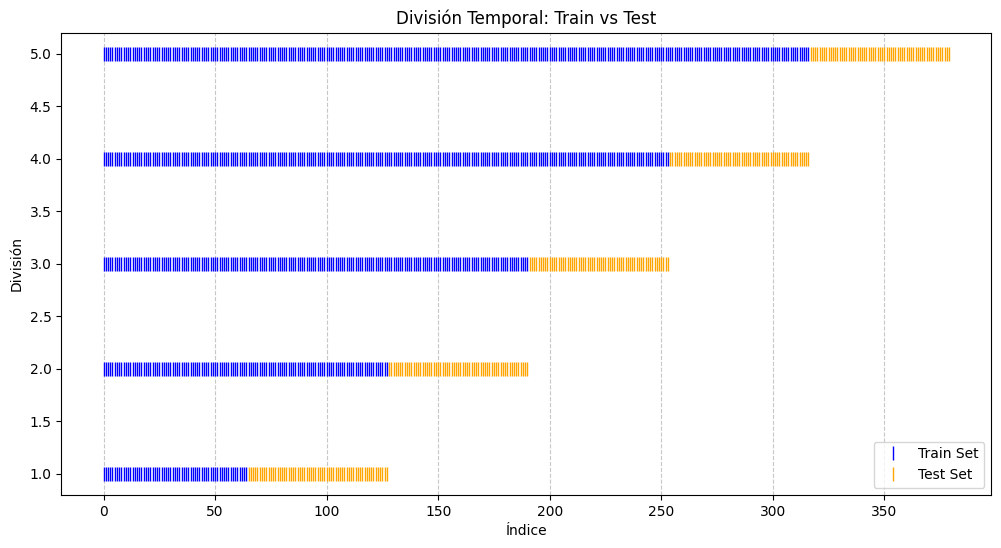

In [139]:
# Crear la figura
plt.figure(figsize=(12, 6))

# Iterar sobre las divisiones
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Representar el conjunto de entrenamiento
    plt.plot(train_index, [i + 1] * len(train_index), '|', color='blue', label='Train Set' if i == 0 else "", markersize=10)
    # Representar el conjunto de prueba
    plt.plot(test_index, [i + 1] * len(test_index), '|', color='orange', label='Test Set' if i == 0 else "", markersize=10)

# Configurar el gráfico
plt.title("División Temporal: Train vs Test")
plt.xlabel("Índice")
plt.ylabel("División")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

#### Model

In [140]:
class SaveToCSVTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, filename):
        self.filename = filename  # El nombre del archivo CSV donde se guardará el contenido

    def fit(self, X, y=None):
        # No es necesario hacer nada en fit para este transformer
        return self

    def transform(self, X):
        # Guardamos el contenido de X en el archivo CSV
        pd.DataFrame(X).to_csv(self.filename, index=False)
        return X

In [141]:
model = GridSearchCV(
    estimator=Pipeline(
        steps=[
            ('CategoricalFeatures', ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [
                        "home_team_name", 
                        "away_team_name",
                        "home_trainer",
                        "away_trainer",
                        "stadium"
                    ]),
                    ('gameweek', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 38), 
                        np.sin(2 * np.pi * x / 38)
                    ]), validate=True), ["gameweek"])
                ]
            )),
            ("SaveToCSVTransformer", SaveToCSVTransformer(filename="data.csv")),
            ("StandardScaler", StandardScaler(with_mean=True)),
            ("SGDClassifier", SGDClassifier(
                random_state=random_state, 
                max_iter=1000
            ))
        ]
    ),
    param_grid={
        "SGDClassifier__tol": [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    },
    n_jobs=2,
    verbose=4,
)

In [142]:
'''model = GridSearchCV(
    estimator=Pipeline(
        steps=[
            ('CategoricalFeatures', ColumnTransformer(
                transformers=[
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [
                        "home_team_name", 
                        "away_team_name"
                    ]),
                    ('circular_day', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 7), 
                        np.sin(2 * np.pi * x / 7)
                    ]), validate=True), ["day_of_the_week"]),
                    ('circular_hour', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 24), 
                        np.sin(2 * np.pi * x / 24)
                    ]), validate=True), ["hour_of_the_match"]),
                    ('circular_day_year', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 365), 
                        np.sin(2 * np.pi * x / 365)
                    ]), validate=True), ["day_of_year"]),
                    ('game_week', FunctionTransformer(lambda x: np.column_stack([
                        np.cos(2 * np.pi * x / 38), 
                        np.sin(2 * np.pi * x / 38)
                    ]), validate=True), ["Game Week"]),
                    ('passthrough', FunctionTransformer(lambda x: x, validate=True), [
                        'home_team_goal_count',
                        'away_team_goal_count',
                        #'total_goal_count',
                        #'total_goals_at_half_time',	
                        #'home_team_goal_count_half_time',
                        #'away_team_goal_count_half_time',
                        'home_team_shots', 
                        'away_team_shots', 
                        'home_team_shots_on_target', 
                        'away_team_shots_on_target', 
                        'home_team_fouls', 
                        'away_team_fouls',
                        'home_team_yellow_cards',
                        'home_team_red_cards',
                        'away_team_yellow_cards',
                        'away_team_red_cards',
                        #'home_team_first_half_cards',
                        #'home_team_second_half_cards',
                        #'away_team_first_half_cards',
                        #'away_team_second_half_cards',
                        #'home_team_shots_off_target',
                        #'away_team_shots_off_target',	 
                        'home_team_corner_count', 
                        'away_team_corner_count',  
                        'home_ppg', 
                        'away_ppg'
                    ]),
                ]
            )),
            ("SaveToCSVTransformer", SaveToCSVTransformer(filename="data.csv")),
            ("StandardScaler", StandardScaler(with_mean=True)),
            #("MLflowLogger", MLflowLogger(experiment_name="Football_Predictions", run_name="Pipeline_Run")),
            ("SGDClassifier", SGDClassifier(
                random_state=random_state, 
                max_iter=1000
            ))
        ]
    ),
    param_grid={
        "SGDClassifier__tol": [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    },
    n_jobs=2,
    verbose=4,
)'''

'model = GridSearchCV(\n    estimator=Pipeline(\n        steps=[\n            (\'CategoricalFeatures\', ColumnTransformer(\n                transformers=[\n                    (\'cat\', OneHotEncoder(handle_unknown=\'ignore\', sparse_output=False), [\n                        "home_team_name", \n                        "away_team_name"\n                    ]),\n                    (\'circular_day\', FunctionTransformer(lambda x: np.column_stack([\n                        np.cos(2 * np.pi * x / 7), \n                        np.sin(2 * np.pi * x / 7)\n                    ]), validate=True), ["day_of_the_week"]),\n                    (\'circular_hour\', FunctionTransformer(lambda x: np.column_stack([\n                        np.cos(2 * np.pi * x / 24), \n                        np.sin(2 * np.pi * x / 24)\n                    ]), validate=True), ["hour_of_the_match"]),\n                    (\'circular_day_year\', FunctionTransformer(lambda x: np.column_stack([\n                        np.co

In [143]:
# Initialize an MLflow experiment
experiment_name = "BetPredictions"
mlflow.set_experiment(experiment_name)

# Start an MLflow run
with mlflow.start_run(
    run_name="GridSearchCV_Test_4", 
    description="Only 2023-2024 season data. Adding stadiums"
) as run:  # Change the run name and add a description
    scores = []  # To store train and test accuracy for each split
    
    # Loop through each time series split
    for split, (train_index, test_index) in enumerate(tscv.split(X), 1):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Compute metrics
        accuracy_train = model.score(X_train, y_train)
        accuracy_test = model.score(X_test, y_test)
        scores.append((accuracy_train, accuracy_test))

        # Log metrics for each split
        mlflow.log_metric(f"split_{split}_train_accuracy", accuracy_train)
        mlflow.log_metric(f"split_{split}_test_accuracy", accuracy_test)

    # Calculate and log average metrics across all splits
    average_train_accuracy = sum([score[0] for score in scores]) / len(scores)
    average_test_accuracy = sum([score[1] for score in scores]) / len(scores)
    mlflow.log_metric("average_train_accuracy", average_train_accuracy)
    mlflow.log_metric("average_test_accuracy", average_test_accuracy)

    # Print average metrics
    print(f"Average Train Accuracy: {average_train_accuracy:.4f}")
    print(f"Average Test Accuracy: {average_test_accuracy:.4f}")

    # Log the best parameters found by GridSearchCV, if available
    if hasattr(model, 'best_params_'):
        mlflow.log_params(model.best_params_)
        print(f"Best parameters: {model.best_params_}")
    else:
        print("Warning: No best_params_ found in the model. Ensure the model is used properly.")

    # Log features used directly from X
    features_used = X.columns.tolist()  # Extract column names from X
    mlflow.log_param("features", features_used)
    
    # Log the trained model
    mlflow.sklearn.log_model(model.best_estimator_, "best_model_pipeline")

    # Print completion message
    print("Model, metrics, parameters, and features logged to MLflow.")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Average Train Accuracy: 0.7652
Average Test Accuracy: 0.4603
Best parameters: {'SGDClassifier__tol': 0.01}


2025/01/17 17:47:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model, metrics, parameters, and features logged to MLflow.
